In [1]:
    import pandas as pd
    import numpy as np
    from bounds import bounds
    import ast
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import confusion_matrix, classification_report
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Masking, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Bidirectional
    import tensorflow as tf

    # =============================================================================
    # Custom Attention Layer (used by the attention model method)
    # =============================================================================
    class AttentionLayer(tf.keras.layers.Layer):
        def __init__(self, **kwargs):
            super(AttentionLayer, self).__init__(**kwargs)
        
        def build(self, input_shape):
            self.W = self.add_weight(
                name="att_weight",
                shape=(input_shape[-1], input_shape[-1]),
                initializer="glorot_uniform",
                trainable=True
            )
            self.b = self.add_weight(
                name="att_bias",
                shape=(input_shape[-1],),
                initializer="zeros",
                trainable=True
            )
            self.u = self.add_weight(
                name="att_u",
                shape=(input_shape[-1], 1),
                initializer="glorot_uniform",
                trainable=True
            )
            super(AttentionLayer, self).build(input_shape)
        
        def call(self, inputs):
            uit = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
            ait = tf.tensordot(uit, self.u, axes=1)
            ait = tf.squeeze(ait, -1)
            a = tf.nn.softmax(ait, axis=1)
            a = tf.expand_dims(a, -1)
            output = tf.reduce_sum(inputs * a, axis=1)
            return output

    # =============================================================================
    # Main Class Definition
    # =============================================================================
    class ExcelTimeSeriesClassifier:
        def __init__(self, file_name, sheet_names, t5_bounds, pad_value=-10.0):
            """
            Args:
                file_name (str): Path to the Excel file.
                sheet_names (list): List of sheet names to read.
                t5_bounds (tuple): A tuple (t5_lb, t5_ub) for thresholding.
                pad_value (float): The value used for padding.
            """
            self.file_name = file_name
            self.sheet_names = sheet_names
            self.t5_bounds = t5_bounds  # e.g., (t5_lb, t5_ub)
            self.pad_value = pad_value
            
            # To be populated during processing:
            self.df = None
            self.data = None
            self.X_scaled = None
            self.y = None
            self.max_len = None
            self.scaler = None

        @staticmethod
        def safe_literal_eval(value):
            """Safely evaluate a string representation, replacing 'nan' with None."""
            if isinstance(value, str):
                value = value.replace("nan", "None")
            try:
                return ast.literal_eval(value)
            except (ValueError, SyntaxError):
                return None

        def read_data(self):
            """Reads the specified sheets from the Excel file and combines them."""
            dfs = [pd.read_excel(self.file_name, sheet_name=sheet) for sheet in self.sheet_names]
            self.df = pd.concat(dfs, ignore_index=True)
            print("Data shape:", self.df.shape)

        def organize_data(self):
            """
            Processes self.df to extract the time series (MDR), t5 value, and assign a label.
            The label is set as:
                - 'low' if t5 < t5_lb,
                - 'high' if t5 > t5_ub,
                - else 'normal'.
            """
            if self.df is None:
                self.read_data()
            t5_lb, t5_ub = self.t5_bounds
            data = {}
            for _, row in self.df.iterrows():
                if pd.isna(row['t5']):
                    continue
                batch_number = row["batch_number"]
                data[batch_number] = {"MDR": None, "t5": row["t5"], "class": None}

                t_S1 = self.safe_literal_eval(row["MDRTorqueS1"])
                t_S2 = self.safe_literal_eval(row["MDRTorqueS2"])
                if t_S1 is not None and t_S2 is not None:
                    t_vals, S1 = zip(*t_S1)
                    t_vals, S2 = zip(*t_S2)
                    t_vals, S1, S2 = list(t_vals), list(S1), list(S2)
                    # Exclude the first element as indicated
                    MDR = pd.DataFrame({
                        "time": t_vals[1:],
                        "S1": S1[1:],
                        "S2": S2[1:]
                    })
                    MDR.interpolate(method="linear", inplace=True, limit_direction="both")
                    MDR.fillna(method="bfill", inplace=True)
                    MDR.fillna(method="ffill", inplace=True)
                else:
                    continue

                data[batch_number]["MDR"] = MDR

                if row["t5"] < t5_lb:
                    data[batch_number]["class"] = "low"
                elif row["t5"] > t5_ub:
                    data[batch_number]["class"] = "high"
                else:
                    data[batch_number]["class"] = "normal"

            # Remove batches with empty or invalid MDR
            self.data = {k: v for k, v in data.items() if v["MDR"] is not None and not v["MDR"].empty}
            print(f"# low: {len([1 for v in self.data.values() if v['class'] == 'low'])}")
            print(f"# high: {len([1 for v in self.data.values() if v['class'] == 'high'])}")
            print(f"# normal: {len([1 for v in self.data.values() if v['class'] == 'normal'])}")

        def preprocess_data(self):
            """
            Converts the organized data into padded sequences and scales the valid values.
            Sets:
            - self.X_scaled: 3D NumPy array (samples, max_timesteps, features)
            - self.y: Array of integer labels (0: low, 1: normal, 2: high)
            - self.max_len: The maximum sequence length used for padding.
            """
            if self.data is None:
                self.organize_data()
            X, y = [], []
            label_map = {"low": 0, "normal": 1, "high": 2}
            for item in self.data.values():
                sequence = item["MDR"][["S1", "S2"]].values
                X.append(sequence)
                y.append(label_map[item["class"]])
            self.y = np.array(y)

            # Pad sequences to the same length
            self.max_len = max(seq.shape[0] for seq in X)
            X_padded = pad_sequences(X, maxlen=self.max_len, dtype='float32',
                                    padding='post', truncating='post', value=self.pad_value)

            # Scale only the valid (non-padded) values
            all_points = []
            for seq in X_padded:
                valid_rows = seq[~np.all(seq == self.pad_value, axis=1)]
                all_points.append(valid_rows)
            all_points = np.concatenate(all_points, axis=0)

            self.scaler = StandardScaler()
            self.scaler.fit(all_points)

            X_scaled = []
            for seq in X_padded:
                seq_scaled = seq.copy()
                valid_mask = ~np.all(seq == self.pad_value, axis=1)
                if np.sum(valid_mask) > 0:
                    seq_scaled[valid_mask] = self.scaler.transform(seq[valid_mask])
                X_scaled.append(seq_scaled)
            self.X_scaled = np.array(X_scaled)
            print("Preprocessing complete. Data shape:", self.X_scaled.shape)

        def split_data(self, test_size=0.2, random_state=42, stratify=True):
            """
            Splits the processed data into training and test sets.
            
            Returns:
                X_train, X_test, y_train, y_test
            """
            if self.X_scaled is None or self.y is None:
                self.preprocess_data()
            strat = self.y if stratify else None
            X_train, X_test, y_train, y_test = train_test_split(
                self.X_scaled, self.y, test_size=test_size, random_state=random_state, stratify=strat
            )
            print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
            return X_train, X_test, y_train, y_test

        # -------------------------------------------------------------------------
        # Model building and training methods
        # -------------------------------------------------------------------------
        def build_binary_model(self, input_shape):
            """Builds a binary classification model (one-vs-all)."""
            model = Sequential()
            model.add(Masking(mask_value=self.pad_value, input_shape=input_shape))
            model.add(LSTM(64))
            model.add(Dropout(0.5))
            model.add(Dense(1, activation='sigmoid'))
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
            return model

        def train_binary_models(self, X_train, y_train, epochs=20, batch_size=32, validation_split=0.1):
            """
            Trains one binary model per class (0: low, 1: normal, 2: high) in a one-vs-all setting.
            
            Returns:
                A dictionary mapping class index to its trained model.
            """
            from sklearn.utils.class_weight import compute_class_weight
            label_names = {0: "low", 1: "normal", 2: "high"}
            binary_models = {}
            for cls in [0, 1, 2]:
                print(f"\nTraining binary model for class {cls} ({label_names[cls]})")
                y_train_bin = (y_train == cls).astype(int)
                classes_bin = np.unique(y_train_bin)
                class_weights = compute_class_weight(class_weight='balanced', classes=classes_bin, y=y_train_bin)
                class_weight_dict = {cls_val: weight for cls_val, weight in zip(classes_bin, class_weights)}
                model = self.build_binary_model((self.max_len, 2))
                model.fit(X_train, y_train_bin, epochs=epochs, batch_size=batch_size,
                        validation_split=validation_split, class_weight=class_weight_dict, verbose=1)
                binary_models[cls] = model
            return binary_models

        def build_model(self, model_type="lstm"):
            """
            Builds a model based on the desired architecture.
            
            Args:
                model_type (str): One of "lstm", "attention", "cnn_lstm", or "bidirectional".
            
            Returns:
                A compiled Keras model.
            """
            if model_type == "lstm":
                model = Sequential()
                model.add(Masking(mask_value=self.pad_value, input_shape=(self.max_len, 2)))
                model.add(LSTM(64))
                model.add(Dropout(0.5))
                model.add(Dense(3, activation='softmax'))
                model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
                return model

            elif model_type == "attention":
                model = Sequential()
                model.add(Masking(mask_value=self.pad_value, input_shape=(self.max_len, 2)))
                model.add(LSTM(64, return_sequences=True))
                model.add(AttentionLayer())
                model.add(Dropout(0.5))
                model.add(Dense(3, activation='softmax'))
                model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
                return model

            elif model_type == "cnn_lstm":
                model = Sequential()
                model.add(Masking(mask_value=self.pad_value, input_shape=(self.max_len, 2)))
                model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
                model.add(MaxPooling1D(pool_size=2))
                model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
                model.add(MaxPooling1D(pool_size=2))
                model.add(LSTM(64))
                model.add(Dropout(0.5))
                model.add(Dense(3, activation='softmax'))
                model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
                return model

            elif model_type == "bidirectional":
                model = Sequential()
                model.add(Masking(mask_value=self.pad_value, input_shape=(self.max_len, 2)))
                model.add(Bidirectional(LSTM(64)))
                model.add(Dropout(0.5))
                model.add(Dense(3, activation='softmax'))
                model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
                return model

            else:
                raise ValueError("Unsupported model type. Choose from 'lstm', 'attention', 'cnn_lstm', or 'bidirectional'.")

        def train_model(self, model, X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, **kwargs):
            """Generic training method for a given model."""
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                                validation_split=validation_split, verbose=1, **kwargs)
            return history

        def evaluate_model(self, model, X_test, y_test, label_names=["low", "normal", "high"]):
            """
            Evaluates the model on test data and prints loss, accuracy, confusion matrix, and classification report.
            
            Returns:
                Predicted labels.
            """
            test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
            print("Test Loss:", test_loss)
            print("Test Accuracy:", test_acc)
            y_pred_prob = model.predict(X_test)
            y_pred = np.argmax(y_pred_prob, axis=1)
            cm = confusion_matrix(y_test, y_pred)
            print("\nConfusion Matrix:")
            print(cm)
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred, target_names=label_names))
            return y_pred

    # =============================================================================
    # Example Usage
    # =============================================================================
    if __name__ == "__main__":
        # Initialize the classifier with file info and thresholds
        file_name = "DataOn2025Jan08.xlsx"
        sheets = ["NES170K07Line1", "NES170K07Line2"]
        t5_bounds = bounds["170K"]

        clf = ExcelTimeSeriesClassifier(file_name, sheets, t5_bounds)
        
        # Read, organize, and preprocess the data
        clf.read_data()
        clf.organize_data()
        clf.preprocess_data()
        
        # Split into train/test sets
        X_train, X_test, y_train, y_test = clf.split_data(test_size=0.2, random_state=16)
        
        # --- Example 1: Train and evaluate a standard LSTM model ---
        model_lstm = clf.build_model(model_type="lstm")
        clf.train_model(model_lstm, X_train, y_train, epochs=10, batch_size=16)
        clf.evaluate_model(model_lstm, X_test, y_test)
        
        # --- Example 2: Train and evaluate an Attention-based model ---
        model_att = clf.build_model(model_type="attention")
        clf.train_model(model_att, X_train, y_train, epochs=10, batch_size=16)
        clf.evaluate_model(model_att, X_test, y_test)
        
        # --- Example 3: Train and evaluate a CNN-LSTM model ---
        model_cnn_lstm = clf.build_model(model_type="cnn_lstm")
        clf.train_model(model_cnn_lstm, X_train, y_train, epochs=10, batch_size=16)
        clf.evaluate_model(model_cnn_lstm, X_test, y_test)
        
        # --- Example 4: Train and evaluate a Bidirectional LSTM model ---
        model_bi = clf.build_model(model_type="bidirectional")
        clf.train_model(model_bi, X_train, y_train, epochs=10, batch_size=16)
        clf.evaluate_model(model_bi, X_test, y_test)
        
        # --- Example 5: Train binary one-vs-all models ---
        binary_models = clf.train_binary_models(X_train, y_train, epochs=10, batch_size=16)
        # (You would then use each binary model’s prediction to combine a final decision.)

2025-02-14 20:18:52.364746: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-02-14 20:18:52.364786: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Data shape: (20528, 43)
# low: 365
# high: 677
# normal: 7297
Preprocessing complete. Data shape: (8339, 304, 2)
Train shape: (6671, 304, 2) Test shape: (1668, 304, 2)


2025-02-14 20:21:28.910726: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-02-14 20:21:28.910758: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2025-02-14 20:21:28.910785: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2025-02-14 20:21:28.911147: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
376/376 [==============================] - 120s 304ms/step - loss: 0.4952 - accuracy: 0.8714 - val_loss: 0.4275 - val_accuracy: 0.8862
Epoch 2/10
376/376 [==============================] - 95s 253ms/step - loss: 0.4761 - accuracy: 0.8737 - val_loss: 0.4259 - val_accuracy: 0.8862
Epoch 3/10
376/376 [==============================] - 103s 274ms/step - loss: 0.4776 - accuracy: 0.8737 - val_loss: 0.4324 - val_accuracy: 0.8862
Epoch 4/10
376/376 [==============================] - 96s 255ms/step - loss: 0.4723 - accuracy: 0.8737 - val_loss: 0.4290 - val_accuracy: 0.8862
Epoch 5/10
376/376 [==============================] - 92s 244ms/step - loss: 0.4707 - accuracy: 0.8737 - val_loss: 0.4261 - val_accuracy: 0.8862
Epoch 6/10
363/376 [===========================>..] - ETA: 3s - loss: 0.4766 - accuracy: 0.8726

KeyboardInterrupt: 

In [2]:
import pandas as pd
import numpy as np
from bounds import bounds
import ast
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, make_scorer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Bidirectional, BatchNormalization
import tensorflow as tf
from sklearn.utils import class_weight

# Custom Attention Layer (used by the attention model method)
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(
            name="att_weight",
            shape=(input_shape[-1], input_shape[-1]),
            initializer="glorot_uniform",
            trainable=True
        )
        self.b = self.add_weight(
            name="att_bias",
            shape=(input_shape[-1],),
            initializer="zeros",
            trainable=True
        )
        self.u = self.add_weight(
            name="att_u",
            shape=(input_shape[-1], 1),
            initializer="glorot_uniform",
            trainable=True
        )
        super(AttentionLayer, self).build(input_shape)
    
    def call(self, inputs):
        uit = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        ait = tf.tensordot(uit, self.u, axes=1)
        ait = tf.squeeze(ait, -1)
        a = tf.nn.softmax(ait, axis=1)
        a = tf.expand_dims(a, -1)
        output = tf.reduce_sum(inputs * a, axis=1)
        return output

# Main Class Definition
class ExcelTimeSeriesClassifier:
    def __init__(self, file_name, sheet_names, t5_bounds, pad_value=-10.0):
        """
        Args:
            file_name (str): Path to the Excel file.
            sheet_names (list): List of sheet names to read.
            t5_bounds (tuple): A tuple (t5_lb, t5_ub) for thresholding.
            pad_value (float): The value used for padding.
        """
        self.file_name = file_name
        self.sheet_names = sheet_names
        self.t5_bounds = t5_bounds  # e.g., (t5_lb, t5_ub)
        self.pad_value = pad_value
        
        # To be populated during processing:
        self.df = None
        self.data = None
        self.X_scaled = None
        self.y = None
        self.max_len = None
        self.scaler = None

    @staticmethod
    def safe_literal_eval(value):
        """Safely evaluate a string representation, replacing 'nan' with None."""
        if isinstance(value, str):
            value = value.replace("nan", "None")
        try:
            return ast.literal_eval(value)
        except (ValueError, SyntaxError):
            return None

    def read_data(self):
        """Reads the specified sheets from the Excel file and combines them."""
        dfs = [pd.read_excel(self.file_name, sheet_name=sheet) for sheet in self.sheet_names]
        self.df = pd.concat(dfs, ignore_index=True)
        print("Data shape:", self.df.shape)

    def organize_data(self):
        """
        Processes self.df to extract the time series (MDR), t5 value, and assign a label.
        The label is set as:
            - 'low' if t5 < t5_lb,
            - 'high' if t5 > t5_ub,
            - else 'normal'.
        """
        if self.df is None:
            self.read_data()
        t5_lb, t5_ub = self.t5_bounds
        data = {}
        for _, row in self.df.iterrows():
            if pd.isna(row['t5']):
                continue
            batch_number = row["batch_number"]
            data[batch_number] = {"MDR": None, "t5": row["t5"], "class": None}

            t_S1 = self.safe_literal_eval(row["MDRTorqueS1"])
            t_S2 = self.safe_literal_eval(row["MDRTorqueS2"])
            if t_S1 is not None and t_S2 is not None:
                t_vals, S1 = zip(*t_S1)
                t_vals, S2 = zip(*t_S2)
                t_vals, S1, S2 = list(t_vals), list(S1), list(S2)
                # Exclude the first element as indicated
                MDR = pd.DataFrame({
                    "time": t_vals[1:],
                    "S1": S1[1:],
                    "S2": S2[1:]
                })
                MDR.interpolate(method="linear", inplace=True, limit_direction="both")
                MDR.bfill(inplace=True)
                MDR.ffill(inplace=True)
            else:
                continue

            data[batch_number]["MDR"] = MDR

            if row["t5"] < t5_lb:
                data[batch_number]["class"] = "low"
            elif row["t5"] > t5_ub:
                data[batch_number]["class"] = "high"
            else:
                data[batch_number]["class"] = "normal"

        # Remove batches with empty or invalid MDR
        self.data = {k: v for k, v in data.items() if v["MDR"] is not None and not v["MDR"].empty}
        print(f"# low: {len([1 for v in self.data.values() if v['class'] == 'low'])}")
        print(f"# high: {len([1 for v in self.data.values() if v['class'] == 'high'])}")
        print(f"# normal: {len([1 for v in self.data.values() if v['class'] == 'normal'])}")

    def preprocess_data(self):
        """
        Converts the organized data into padded sequences and scales the valid values.
        Sets:
          - self.X_scaled: 3D NumPy array (samples, max_timesteps, features)
          - self.y: Array of integer labels (0: low, 1: normal, 2: high)
          - self.max_len: The maximum sequence length used for padding.
        """
        if self.data is None:
            self.organize_data()
        X, y = [], []
        label_map = {"low": 0, "normal": 1, "high": 2}
        for item in self.data.values():
            sequence = item["MDR"][["S1", "S2"]].values
            X.append(sequence)
            y.append(label_map[item["class"]])
        self.y = np.array(y)

        # Pad sequences to the same length
        self.max_len = max(seq.shape[0] for seq in X)
        X_padded = pad_sequences(X, maxlen=self.max_len, dtype='float32',
                                 padding='post', truncating='post', value=self.pad_value)

        # Scale only the valid (non-padded) values
        all_points = []
        for seq in X_padded:
            valid_rows = seq[~np.all(seq == self.pad_value, axis=1)]
            all_points.append(valid_rows)
        all_points = np.concatenate(all_points, axis=0)

        self.scaler = StandardScaler()
        self.scaler.fit(all_points)

        X_scaled = []
        for seq in X_padded:
            seq_scaled = seq.copy()
            valid_mask = ~np.all(seq == self.pad_value, axis=1)
            if np.sum(valid_mask) > 0:
                seq_scaled[valid_mask] = self.scaler.transform(seq[valid_mask])
            X_scaled.append(seq_scaled)
        self.X_scaled = np.array(X_scaled)
        print("Preprocessing complete. Data shape:", self.X_scaled.shape)

    def split_data(self, test_size=0.2, random_state=42, stratify=True):
        """
        Splits the processed data into training and test sets.
        
        Returns:
            X_train, X_test, y_train, y_test
        """
        if self.X_scaled is None or self.y is None:
            self.preprocess_data()
        strat = self.y if stratify else None
        X_train, X_test, y_train, y_test = train_test_split(
            self.X_scaled, self.y, test_size=test_size, random_state=random_state, stratify=strat
        )
        print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
        return X_train, X_test, y_train, y_test

    def build_cnn_lstm_model(self, input_shape):
        """Builds an enhanced CNN-LSTM model with BatchNormalization and class weights."""
        model = Sequential()
        model.add(Masking(mask_value=self.pad_value, input_shape=input_shape))
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
        model.add(BatchNormalization())  # Batch Normalization
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
        model.add(BatchNormalization())  # Batch Normalization
        model.add(MaxPooling1D(pool_size=2))
        model.add(LSTM(64))
        model.add(Dropout(0.5))
        model.add(Dense(3, activation='softmax'))
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

    def train_cnn_lstm_model(self, model, X_train, y_train, epochs=20, batch_size=32, validation_split=0.1):
        """Trains the CNN-LSTM model with class weights."""
        # Compute class weights to handle imbalanced data
        class_labels = np.unique(y_train)
        class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=class_labels, y=y_train)
        class_weight_dict = dict(zip(class_labels, class_weights))  # Convert to dictionary
        
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                            validation_split=validation_split, class_weight=class_weight_dict, verbose=1)
        return history

    def evaluate_cnn_lstm_model(self, model, X_test, y_test, label_names=["low", "normal", "high"]):
        """Evaluates the CNN-LSTM model with F1-score and detailed metrics."""
        y_pred = np.argmax(model.predict(X_test), axis=1)
        
        # Calculate metrics
        f1 = f1_score(y_test, y_pred, average='weighted')
        cm = confusion_matrix(y_test, y_pred)
        cr = classification_report(y_test, y_pred, target_names=label_names)
        
        print("Weighted F1 Score:", f1)
        print("\nConfusion Matrix:")
        print(cm)
        print("\nClassification Report:")
        print(cr)
        return y_pred

# Example Usage
if __name__ == "__main__":
    # Initialize the classifier
    file_name = "DataOn2025Jan08.xlsx"
    sheets = ["NES170K07Line1", "NES170K07Line2"]
    t5_bounds = bounds["170K"]

    clf = ExcelTimeSeriesClassifier(file_name, sheets, t5_bounds)
    
    # Read, organize, and preprocess the data
    clf.read_data()
    clf.organize_data()
    clf.preprocess_data()
    
    # Split into train/test sets
    X_train, X_test, y_train, y_test = clf.split_data(test_size=0.2, random_state=16, stratify=True)
    
    # Build, train, and evaluate the CNN-LSTM model
    cnn_lstm_model = clf.build_cnn_lstm_model((clf.max_len, 2))
    history = clf.train_cnn_lstm_model(cnn_lstm_model, X_train, y_train, epochs=10, batch_size=16)
    y_pred = clf.evaluate_cnn_lstm_model(cnn_lstm_model, X_test, y_test)


Data shape: (20528, 43)
# low: 365
# high: 677
# normal: 7297
Preprocessing complete. Data shape: (8339, 304, 2)
Train shape: (6671, 304, 2) Test shape: (1668, 304, 2)
Epoch 1/10
376/376 [==============================] - 28s 66ms/step - loss: 1.1793 - accuracy: 0.3507 - val_loss: 1.1456 - val_accuracy: 0.0719
Epoch 2/10
376/376 [==============================] - 24s 64ms/step - loss: 1.1257 - accuracy: 0.3138 - val_loss: 1.0745 - val_accuracy: 0.1737
Epoch 3/10
376/376 [==============================] - 24s 64ms/step - loss: 1.1160 - accuracy: 0.3008 - val_loss: 1.0976 - val_accuracy: 0.2410
Epoch 4/10
376/376 [==============================] - 24s 64ms/step - loss: 1.1047 - accuracy: 0.2849 - val_loss: 1.0077 - val_accuracy: 0.6692
Epoch 5/10
376/376 [==============================] - 24s 64ms/step - loss: 1.1043 - accuracy: 0.2702 - val_loss: 1.0700 - val_accuracy: 0.3817
Epoch 6/10
376/376 [==============================] - 24s 64ms/step - loss: 1.1052 - accuracy: 0.3402 - val_loss

In [3]:
import pandas as pd
import numpy as np
from bounds import bounds
import ast
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Bidirectional, BatchNormalization
import tensorflow as tf
from sklearn.utils import class_weight
from sklearn.svm import OneClassSVM

# Custom Attention Layer (used by the attention model method)
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(
            name="att_weight",
            shape=(input_shape[-1], input_shape[-1]),
            initializer="glorot_uniform",
            trainable=True
        )
        self.b = self.add_weight(
            name="att_bias",
            shape=(input_shape[-1],),
            initializer="zeros",
            trainable=True
        )
        self.u = self.add_weight(
            name="att_u",
            shape=(input_shape[-1], 1),
            initializer="glorot_uniform",
            trainable=True
        )
        super(AttentionLayer, self).build(input_shape)
    
    def call(self, inputs):
        uit = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        ait = tf.tensordot(uit, self.u, axes=1)
        ait = tf.squeeze(ait, -1)
        a = tf.nn.softmax(ait, axis=1)
        a = tf.expand_dims(a, -1)
        output = tf.reduce_sum(inputs * a, axis=1)
        return output

# Main Class Definition
class ExcelTimeSeriesClassifier:
    def __init__(self, file_name, sheet_names, t5_bounds, pad_value=-10.0):
        """
        Args:
            file_name (str): Path to the Excel file.
            sheet_names (list): List of sheet names to read.
            t5_bounds (tuple): A tuple (t5_lb, t5_ub) for thresholding.
            pad_value (float): The value used for padding.
        """
        self.file_name = file_name
        self.sheet_names = sheet_names
        self.t5_bounds = t5_bounds  # e.g., (t5_lb, t5_ub)
        self.pad_value = pad_value
        
        # To be populated during processing:
        self.df = None
        self.data = None
        self.X_scaled = None
        self.y = None
        self.max_len = None
        self.scaler = None

    @staticmethod
    def safe_literal_eval(value):
        """Safely evaluate a string representation, replacing 'nan' with None."""
        if isinstance(value, str):
            value = value.replace("nan", "None")
        try:
            return ast.literal_eval(value)
        except (ValueError, SyntaxError):
            return None

    def read_data(self):
        """Reads the specified sheets from the Excel file and combines them."""
        dfs = [pd.read_excel(self.file_name, sheet_name=sheet) for sheet in self.sheet_names]
        self.df = pd.concat(dfs, ignore_index=True)
        print("Data shape:", self.df.shape)

    def organize_data(self):
        """
        Processes self.df to extract the time series (MDR), t5 value, and assign a label.
        The label is set as:
            - 'low' if t5 < t5_lb,
            - 'high' if t5 > t5_ub,
            - else 'normal'.
        """
        if self.df is None:
            self.read_data()
        t5_lb, t5_ub = self.t5_bounds
        data = {}
        for _, row in self.df.iterrows():
            if pd.isna(row['t5']):
                continue
            batch_number = row["batch_number"]
            data[batch_number] = {"MDR": None, "t5": row["t5"], "class": None}

            t_S1 = self.safe_literal_eval(row["MDRTorqueS1"])
            t_S2 = self.safe_literal_eval(row["MDRTorqueS2"])
            if t_S1 is not None and t_S2 is not None:
                t_vals, S1 = zip(*t_S1)
                t_vals, S2 = zip(*t_S2)
                t_vals, S1, S2 = list(t_vals), list(S1), list(S2)
                # Exclude the first element as indicated
                MDR = pd.DataFrame({
                    "time": t_vals[1:],
                    "S1": S1[1:],
                    "S2": S2[1:]
                })
                MDR.interpolate(method="linear", inplace=True, limit_direction="both")
                MDR.bfill(inplace=True)
                MDR.ffill(inplace=True)
            else:
                continue

            data[batch_number]["MDR"] = MDR

            if row["t5"] < t5_lb:
                data[batch_number]["class"] = "low"
            elif row["t5"] > t5_ub:
                data[batch_number]["class"] = "high"
            else:
                data[batch_number]["class"] = "normal"

        # Remove batches with empty or invalid MDR
        self.data = {k: v for k, v in data.items() if v["MDR"] is not None and not v["MDR"].empty}
        print(f"# low: {len([1 for v in self.data.values() if v['class'] == 'low'])}")
        print(f"# high: {len([1 for v in self.data.values() if v['class'] == 'high'])}")
        print(f"# normal: {len([1 for v in self.data.values() if v['class'] == 'normal'])}")

    def preprocess_data(self):
        """
        Converts the organized data into padded sequences and scales the valid values.
        Sets:
          - self.X_scaled: 3D NumPy array (samples, max_timesteps, features)
          - self.y: Array of integer labels (0: low, 1: normal, 2: high)
          - self.max_len: The maximum sequence length used for padding.
        """
        if self.data is None:
            self.organize_data()
        X, y = [], []
        label_map = {"low": 0, "normal": 1, "high": 2}
        for item in self.data.values():
            sequence = item["MDR"][["S1", "S2"]].values
            X.append(sequence)
            y.append(label_map[item["class"]])
        self.y = np.array(y)

        # Pad sequences to the same length
        self.max_len = max(seq.shape[0] for seq in X)
        X_padded = pad_sequences(X, maxlen=self.max_len, dtype='float32',
                                 padding='post', truncating='post', value=self.pad_value)

        # Scale only the valid (non-padded) values
        all_points = []
        for seq in X_padded:
            valid_rows = seq[~np.all(seq == self.pad_value, axis=1)]
            all_points.append(valid_rows)
        all_points = np.concatenate(all_points, axis=0)

        self.scaler = StandardScaler()
        self.scaler.fit(all_points)

        X_scaled = []
        for seq in X_padded:
            seq_scaled = seq.copy()
            valid_mask = ~np.all(seq == self.pad_value, axis=1)
            if np.sum(valid_mask) > 0:
                seq_scaled[valid_mask] = self.scaler.transform(seq[valid_mask])
            X_scaled.append(seq_scaled)
        self.X_scaled = np.array(X_scaled)
        print("Preprocessing complete. Data shape:", self.X_scaled.shape)

    def split_data(self, test_size=0.2, random_state=42, stratify=True):
        """
        Splits the processed data into training and test sets.
        
        Returns:
            X_train, X_test, y_train, y_test
        """
        if self.X_scaled is None or self.y is None:
            self.preprocess_data()
        strat = self.y if stratify else None
        X_train, X_test, y_train, y_test = train_test_split(
            self.X_scaled, self.y, test_size=test_size, random_state=random_state, stratify=strat
        )
        print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
        return X_train, X_test, y_train, y_test

    def build_cnn_lstm_model(self, input_shape):
        """Builds an enhanced CNN-LSTM model with BatchNormalization and class weights."""
        model = Sequential()
        model.add(Masking(mask_value=self.pad_value, input_shape=input_shape))
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
        model.add(BatchNormalization())  # Batch Normalization
        model.add(MaxPooling1D(pool_size=2))
        model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))
        model.add(BatchNormalization())  # Batch Normalization
        model.add(MaxPooling1D(pool_size=2))
        model.add(LSTM(64))
        model.add(Dropout(0.5))
        model.add(Dense(3, activation='softmax'))
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

    def train_cnn_lstm_model(self, model, X_train, y_train, epochs=20, batch_size=32, validation_split=0.1):
        """Trains the CNN-LSTM model with class weights."""
        # Compute class weights to handle imbalanced data
        class_labels = np.unique(y_train)
        class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=class_labels, y=y_train)
        class_weight_dict = dict(zip(class_labels, class_weights))  # Convert to dictionary
        
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                            validation_split=validation_split, class_weight=class_weight_dict, verbose=1)
        return history

    def evaluate_cnn_lstm_model(self, model, X_test, y_test, label_names=["low", "normal", "high"]):
        """Evaluates the CNN-LSTM model with F1-score and detailed metrics."""
        y_pred = np.argmax(model.predict(X_test), axis=1)
        
        # Calculate metrics
        f1 = f1_score(y_test, y_pred, average='weighted')
        cm = confusion_matrix(y_test, y_pred)
        cr = classification_report(y_test, y_pred, target_names=label_names)
        
        print("Weighted F1 Score:", f1)
        print("\nConfusion Matrix:")
        print(cm)
        print("\nClassification Report:")
        print(cr)
        return y_pred
        
    def create_normal_dataset(self):
        """Creates a dataset containing only 'normal' data points."""
        normal_data = [item["MDR"][["S1", "S2"]].values for item in self.data.values() if item["class"] == "normal"]
        
        if not normal_data:
            raise ValueError("No 'normal' data points found. Cannot train anomaly detection model.")

        # Pad sequences to the same length
        self.max_len = max(seq.shape[0] for seq in normal_data)
        X_padded = pad_sequences(normal_data, maxlen=self.max_len, dtype='float32',
                                padding='post', truncating='post', value=self.pad_value)

        # Scale only the valid (non-padded) values
        all_points = []
        for seq in X_padded:
            valid_rows = seq[~np.all(seq == self.pad_value, axis=1)]
            all_points.append(valid_rows)
        all_points = np.concatenate(all_points, axis=0)

        self.scaler = StandardScaler()
        self.scaler.fit(all_points)

        X_scaled = []
        for seq in X_padded:
            seq_scaled = seq.copy()
            valid_mask = ~np.all(seq == self.pad_value, axis=1)
            if np.sum(valid_mask) > 0:
                seq_scaled[valid_mask] = self.scaler.transform(seq[valid_mask])
            X_scaled.append(seq_scaled)
        X_normal = np.array(X_scaled)
        return X_normal
    
    def build_anomaly_detection_model(self, input_shape, nu=0.05):
        """Builds a OneClassSVM anomaly detection model."""
        model = OneClassSVM(kernel='rbf', gamma='auto', nu=nu)
        return model

    def train_anomaly_detection_model(self, model, X_normal):
        """Trains the anomaly detection model on 'normal' data."""
        # Reshape X_normal to 2D array
        n_samples, time_steps, n_features = X_normal.shape
        X_normal_2d = X_normal.reshape((n_samples * time_steps, n_features))

        # Remove rows with pad_value
        X_normal_2d = X_normal_2d[~np.any(X_normal_2d == self.pad_value, axis=1)]

        model.fit(X_normal_2d)

        return model

    def evaluate_anomaly_detection_model(self, model, X_test, y_test, label_names=["low", "normal", "high"]):
        """Evaluates the anomaly detection model on 'low' and 'high' data."""
        # Reshape X_test to 2D array
        n_samples, time_steps, n_features = X_test.shape
        X_test_2d = X_test.reshape((n_samples * time_steps, n_features))

        # Remove rows with pad_value
        X_test_2d = X_test_2d[~np.any(X_test_2d == self.pad_value, axis=1)]

        # Predict anomalies (-1 for anomaly, 1 for inlier)
        y_pred = model.predict(X_test_2d)

        # Convert predictions to anomaly (1) / normal (0) labels
        y_pred_binary = np.where(y_pred == -1, 1, 0)  # 1 for anomaly, 0 for normal

        # Create binary labels for the test set (1 for anomaly, 0 for normal)
        y_test_binary = np.where(y_test != 1, 1, 0)  # Assuming 'normal' class is labeled as 1

        # Calculate evaluation metrics
        f1 = f1_score(y_test_binary[:len(y_pred_binary)], y_pred_binary, average='binary')
        cm = confusion_matrix(y_test_binary[:len(y_pred_binary)], y_pred_binary)
        cr = classification_report(y_test_binary[:len(y_pred_binary)], y_pred_binary, target_names=["normal", "anomaly"])

        print("Anomaly Detection - Weighted F1 Score:", f1)
        print("\nAnomaly Detection - Confusion Matrix:")
        print(cm)
        print("\nAnomaly Detection - Classification Report:")
        print(cr)

# Example Usage
if __name__ == "__main__":
    # Initialize the classifier
    file_name = "DataOn2025Jan08.xlsx"
    sheets = ["NES170K07Line1", "NES170K07Line2"]
    t5_bounds = bounds["170K"]

    clf = ExcelTimeSeriesClassifier(file_name, sheets, t5_bounds)
    
    # Read, organize, and preprocess the data
    clf.read_data()
    clf.organize_data()
    clf.preprocess_data()
    
    # Split into train/test sets
    X_train, X_test, y_train, y_test = clf.split_data(test_size=0.2, random_state=16, stratify=True)

    # Create the 'normal' dataset
    X_normal = clf.create_normal_dataset()
    
    # Build, train, and evaluate the anomaly detection model
    anomaly_model = clf.build_anomaly_detection_model(input_shape=(clf.max_len, 2))
    anomaly_model = clf.train_anomaly_detection_model(anomaly_model, X_normal)
    clf.evaluate_anomaly_detection_model(anomaly_model, X_test, y_test)


Data shape: (20528, 43)
# low: 365
# high: 677
# normal: 7297
Preprocessing complete. Data shape: (8339, 304, 2)
Train shape: (6671, 304, 2) Test shape: (1668, 304, 2)


Data shape: (20528, 43)
# low: 365
# high: 677
# normal: 7297
Total sequences: 8339
Class distribution: Counter({0: 7297, 1: 1042})
Max sequence length: 304
Training on normal sequences: (5837, 304, 2)
Validation on normal sequences: (1460, 304, 2)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_2 (Masking)         (None, 304, 2)            0         
                                                                 
 lstm_4 (LSTM)               (None, 16)                1216      
                                                                 
 repeat_vector_2 (RepeatVect  (None, 304, 16)          0         
 or)                                                             
                                                                 
 lstm_5 (LSTM)               (None, 304, 16)           2112      
                                                                 
 ti

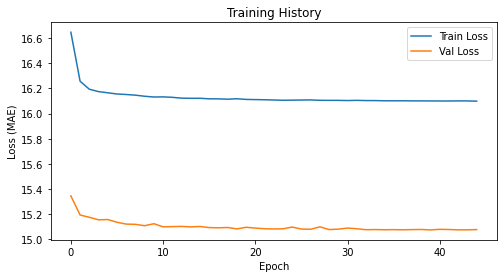

Training reconstruction error (mean): 0.08276644
Anomaly detection threshold: 0.5277

Confusion Matrix:
[[7191  106]
 [1013   29]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.88      0.99      0.93      7297
     Anomaly       0.21      0.03      0.05      1042

    accuracy                           0.87      8339
   macro avg       0.55      0.51      0.49      8339
weighted avg       0.79      0.87      0.82      8339



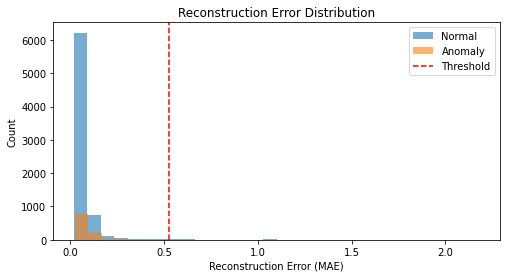

In [3]:
"""
Anomaly Detection on Imbalanced Time-Series Data Using an LSTM Autoencoder

Steps:
1. Read and organize the Excel data.
2. Extract time-series (S1, S2) from each batch.
3. Label data as “normal” (for training) or “anomalous” (low/high).
4. Scale and pad sequences.
5. Build an LSTM autoencoder that is trained only on normal sequences.
6. Compute a reconstruction error threshold from the training data.
7. Evaluate the model on all data (normal and anomalies) using the reconstruction error.
"""

import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# ---------------------------
# 1. Read Excel Data and Organize It
# ---------------------------

# Assumes that you have a dictionary named "bounds" defined in bounds.py
# which holds the threshold values for your data.
from bounds import bounds

file_name = "DataOn2025Jan08.xlsx"
df1 = pd.read_excel(file_name, sheet_name="NES170K07Line2")
df2 = pd.read_excel(file_name, sheet_name="NES170K07Line1")
df = pd.concat([df1, df2], ignore_index=True)
print("Data shape:", df.shape)

# Get t5 thresholds from bounds dictionary
t5_lb = bounds["170K"][0]
t5_ub = bounds["170K"][1]

def safe_literal_eval(value):
    """Safely evaluate a string representation, replacing 'nan' with None."""
    if isinstance(value, str):
        value = value.replace("nan", "None")
    try:
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        return None

def organized_data(df, t5_lb, t5_ub):
    """
    Process each row to extract the time-series (MDR), target t5,
    and assign a region label ('low', 'normal', 'high') based on thresholds.
    """
    data = {}
    for index, row in df.iterrows():
        if pd.isna(row['t5']):
            continue
        batch_number = row["batch_number"]
        data[batch_number] = {"MDR": None, "t5": row["t5"], "class": None}

        t_S1 = safe_literal_eval(row["MDRTorqueS1"])
        t_S2 = safe_literal_eval(row["MDRTorqueS2"])
        if t_S1 is not None and t_S2 is not None:
            # Unpack the tuples (time, value)
            t_vals, S1 = zip(*t_S1)
            t_vals, S2 = zip(*t_S2)
            t_vals, S1, S2 = list(t_vals), list(S1), list(S2)
            # Exclude the first element as indicated
            MDR = pd.DataFrame({
                "time": t_vals[1:],
                "S1": S1[1:],
                "S2": S2[1:],
            })
            # Interpolate and fill missing values
            MDR.interpolate(method="linear", inplace=True, limit_direction="both")
            MDR.fillna(method="bfill", inplace=True)
            MDR.fillna(method="ffill", inplace=True)
            # Drop any rows that still contain NaN values
            MDR.dropna(inplace=True)
        else:
            continue

        data[batch_number]["MDR"] = MDR

        # Assign class label based on t5 thresholds
        if row["t5"] < t5_lb:
            data[batch_number]["class"] = "low"
        elif row["t5"] > t5_ub:
            data[batch_number]["class"] = "high"
        else:
            data[batch_number]["class"] = "normal"

    # Remove batches with empty MDR
    data = {k: v for k, v in data.items() if v["MDR"] is not None and not v["MDR"].empty}
    return data

# Organize the data
data = organized_data(df, t5_lb, t5_ub)
print(f"# low: {len({k: v for k, v in data.items() if v['class']=='low'})}")
print(f"# high: {len({k: v for k, v in data.items() if v['class']=='high'})}")
print(f"# normal: {len({k: v for k, v in data.items() if v['class']=='normal'})}")

# ---------------------------
# 2. Extract Sequences and Prepare Labels
# ---------------------------
# We will extract the S1 and S2 time-series for each batch.
# For anomaly detection, we treat “normal” as class 0 and “low”/“high” as anomalies (class 1).

all_sequences = []
all_labels = []  # 0 for normal, 1 for anomaly
original_lengths = []  # To keep track of each sequence's true length (before padding)

for batch_id, info in data.items():
    # Get the (S1, S2) sequence from the MDR DataFrame
    seq = info["MDR"][["S1", "S2"]].values.astype(np.float32)
    if len(seq) == 0:
        continue
    all_sequences.append(seq)
    original_lengths.append(len(seq))
    label = 0 if info["class"] == "normal" else 1
    all_labels.append(label)

print(f"Total sequences: {len(all_sequences)}")
print(f"Class distribution: {Counter(all_labels)}")

# ---------------------------
# 3. Scale the Data (Using Only Normal Data for Fitting)
# ---------------------------
# We will fit a StandardScaler on the normal sequences (non-anomalous).
normal_sequences = [seq for seq, lab in zip(all_sequences, all_labels) if lab == 0]

# Concatenate all normal sequence data points to fit the scaler
normal_data_points = np.vstack(normal_sequences)
scaler = StandardScaler()
scaler.fit(normal_data_points)

# Now apply the scaler to all sequences. If any NaNs appear, replace them with 0.
scaled_sequences = []
for seq in all_sequences:
    scaled_seq = scaler.transform(seq)
    if np.isnan(scaled_seq).any():
        print("NaN found after scaling. Replacing NaN with 0.")
        scaled_seq = np.nan_to_num(scaled_seq, nan=0.0)
    scaled_sequences.append(scaled_seq)

# ---------------------------
# 4. Pad the Sequences
# ---------------------------
# To handle variable-length sequences we pad them to the length of the longest sequence.
# We choose a pad value that is unlikely to be produced by the scaler.
pad_value = -999.0
max_seq_len = max(len(seq) for seq in scaled_sequences)
print("Max sequence length:", max_seq_len)

padded_sequences = pad_sequences(
    scaled_sequences,
    maxlen=max_seq_len,
    dtype='float32',
    padding='post',
    truncating='post',
    value=pad_value
)

# Convert labels to numpy array
all_labels = np.array(all_labels)

# ---------------------------
# 5. Split Training (Normal Only) and Validation Data
# ---------------------------
# We train the autoencoder only on the normal data.
# First, get indices of normal samples.
normal_idx = np.where(all_labels == 0)[0]
X_normal = padded_sequences[normal_idx]

# Split normal data into training and validation sets
X_train, X_val = train_test_split(X_normal, test_size=0.2, random_state=42)
print("Training on normal sequences:", X_train.shape)
print("Validation on normal sequences:", X_val.shape)

# ---------------------------
# 6. Build the LSTM Autoencoder
# ---------------------------
latent_dim = 16

# Use gradient clipping in the optimizer to help with exploding gradients
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)

model = Sequential([
    # The Masking layer will ignore the padded timesteps (with value = pad_value)
    Masking(mask_value=pad_value, input_shape=(max_seq_len, 2)),
    # Use the default activation ('tanh') for numerical stability
    LSTM(latent_dim, return_sequences=False),
    RepeatVector(max_seq_len),
    LSTM(latent_dim, return_sequences=True),
    TimeDistributed(Dense(2))
])

model.compile(optimizer=optimizer, loss='mae')
model.summary()

# ---------------------------
# 7. Train the Autoencoder
# ---------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, X_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, X_val),
    callbacks=[early_stop],
    shuffle=True
)

# Plot training history
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss (MAE)")
plt.legend()
plt.title("Training History")
plt.show()

# ---------------------------
# 8. Determine a Reconstruction Error Threshold
# ---------------------------
# Compute reconstruction errors on the training (normal) set.
def compute_reconstruction_error(original, reconstructed, pad_val=pad_value):
    """
    Computes the mean absolute error per sequence,
    ignoring the padded timesteps.
    """
    errors = []
    # Loop over each sequence
    for orig_seq, recon_seq in zip(original, reconstructed):
        # Create a mask: True for timesteps that are NOT padded.
        mask = ~np.all(orig_seq == pad_val, axis=-1)
        if np.sum(mask) == 0:
            errors.append(0.0)
        else:
            error = np.mean(np.abs(orig_seq[mask] - recon_seq[mask]))
            errors.append(error)
    return np.array(errors)

# Get reconstruction error for X_train
X_train_pred = model.predict(X_train)
train_errors = compute_reconstruction_error(X_train, X_train_pred)
print("Training reconstruction error (mean):", np.mean(train_errors))

# Set threshold as mean + 3*std (adjust multiplier as needed)
threshold = np.mean(train_errors) + 3 * np.std(train_errors)
print("Anomaly detection threshold: {:.4f}".format(threshold))

# ---------------------------
# 9. Evaluate on All Data (Normal and Anomalies)
# ---------------------------
X_all = padded_sequences  # All sequences (normal and anomalies)
y_true = all_labels       # 0: normal, 1: anomaly

# Reconstruct all sequences
X_all_pred = model.predict(X_all)
all_errors = compute_reconstruction_error(X_all, X_all_pred)

# Classify sequences as anomalous if reconstruction error > threshold
y_pred = (all_errors > threshold).astype(int)

print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Normal", "Anomaly"]))

# ---------------------------
# 10. Visualize the Error Distribution
# ---------------------------
plt.figure(figsize=(8, 4))
plt.hist(all_errors[y_true == 0], bins=30, alpha=0.6, label='Normal')
plt.hist(all_errors[y_true == 1], bins=30, alpha=0.6, label='Anomaly')
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel("Reconstruction Error (MAE)")
plt.ylabel("Count")
plt.title("Reconstruction Error Distribution")
plt.legend()
plt.show()


In [5]:
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# ---------------------------
# 1. Read Excel Data and Organize It
# ---------------------------
# Assumes that you have a dictionary named "bounds" defined in bounds.py
# which holds the threshold values for your data.
from bounds import bounds

file_name = "DataOn2025Jan08.xlsx"
df1 = pd.read_excel(file_name, sheet_name="NES170K07Line2")
df2 = pd.read_excel(file_name, sheet_name="NES170K07Line1")
df = pd.concat([df1, df2], ignore_index=True)
print("Data shape:", df.shape)

# Get t5 thresholds from bounds dictionary
t5_lb = bounds["170K"][0]
t5_ub = bounds["170K"][1]

def safe_literal_eval(value):
    """Safely evaluate a string representation, replacing 'nan' with None."""
    if isinstance(value, str):
        value = value.replace("nan", "None")
    try:
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        return None

def organized_data(df, t5_lb, t5_ub):
    """
    Process each row to extract the time-series (MDR), target t5,
    and assign a region label ('low', 'normal', 'high') based on thresholds.
    """
    data = {}
    for index, row in df.iterrows():
        if pd.isna(row['t5']):
            continue
        batch_number = row["batch_number"]
        data[batch_number] = {"MDR": None, "t5": row["t5"], "class": None}

        t_S1 = safe_literal_eval(row["MDRTorqueS1"])
        t_S2 = safe_literal_eval(row["MDRTorqueS2"])
        if t_S1 is not None and t_S2 is not None:
            # Unpack the tuples (time, value)
            t_vals, S1 = zip(*t_S1)
            t_vals, S2 = zip(*t_S2)
            t_vals, S1, S2 = list(t_vals), list(S1), list(S2)
            # Exclude the first element as indicated
            MDR = pd.DataFrame({
                "time": t_vals[1:],
                "S1": S1[1:],
                "S2": S2[1:],
            })
            # Interpolate and fill missing values
            MDR.interpolate(method="linear", inplace=True, limit_direction="both")
            MDR.fillna(method="bfill", inplace=True)
            MDR.fillna(method="ffill", inplace=True)
            # Drop any rows that still contain NaN values
            MDR.dropna(inplace=True)
        else:
            continue

        data[batch_number]["MDR"] = MDR

        # Assign class label based on t5 thresholds
        if row["t5"] < t5_lb:
            data[batch_number]["class"] = "low"
        elif row["t5"] > t5_ub:
            data[batch_number]["class"] = "high"
        else:
            data[batch_number]["class"] = "normal"

    # Remove batches with empty MDR
    data = {k: v for k, v in data.items() if v["MDR"] is not None and not v["MDR"].empty}
    return data

# Organize the data
data = organized_data(df, t5_lb, t5_ub)
print("Total runs after organization:", len(data))

# ---------------------------
# 2. Split Data into Training/Validation (normal) and Testing (abnormal)
# ---------------------------
# Normal runs (t5 between t5_lb and t5_ub) are used for training and validation.
normal_data = {k: v for k, v in data.items() if v["class"] == "normal"}
abnormal_data = {k: v for k, v in data.items() if v["class"] != "normal"}

# Extract the MDR time series (only S1 and S2) as numpy arrays.
normal_sequences = [v["MDR"][["S1", "S2"]].values for v in normal_data.values()]
abnormal_sequences = [v["MDR"][["S1", "S2"]].values for v in abnormal_data.values()]

print("Normal runs:", len(normal_sequences))
print("Abnormal runs:", len(abnormal_sequences))

# Split normal data into training (80%) and validation (20%).
train_seq, val_seq = train_test_split(normal_sequences, test_size=0.2, random_state=42)
print("Training runs:", len(train_seq))
print("Validation runs:", len(val_seq))
# Testing data will be all abnormal runs.
test_seq = abnormal_sequences

# ---------------------------
# 3. Normalize Data Using Training Min/Max
# ---------------------------
# Compute global min and max for S1 and S2 from the training data.
train_concat = np.concatenate(train_seq, axis=0)  # shape (total_timesteps, 2)
min_vals = train_concat.min(axis=0)
max_vals = train_concat.max(axis=0)
print("Training min (S1, S2):", min_vals)
print("Training max (S1, S2):", max_vals)

def normalize_seq(seq, min_vals, max_vals):
    """Normalize a sequence given min and max values (per feature),
    avoiding division by zero if a feature is constant."""
    denom = max_vals - min_vals
    # Avoid division by zero: if any denom is 0, set it to 1.
    denom = np.where(denom == 0, 1, denom)
    return (seq - min_vals) / denom

# Normalize all sequences.
train_seq = [normalize_seq(seq, min_vals, max_vals) for seq in train_seq]
val_seq   = [normalize_seq(seq, min_vals, max_vals) for seq in val_seq]
test_seq  = [normalize_seq(seq, min_vals, max_vals) for seq in test_seq]

# ---------------------------
# 4. Pad Sequences to Handle Varying Lengths
# ---------------------------
# Find the maximum sequence length across all datasets.
all_lengths = [len(seq) for seq in train_seq + val_seq + test_seq]
max_length = max(all_lengths)
print("Padding all sequences to length:", max_length)

# IMPORTANT: Since after normalization valid values lie roughly in [0,1],
# we choose a pad value (here -1) that is outside that range.
train_seq_padded = pad_sequences(train_seq, maxlen=max_length, dtype="float32",
                                 padding="post", truncating="post", value=-1.0)
val_seq_padded   = pad_sequences(val_seq, maxlen=max_length, dtype="float32",
                                 padding="post", truncating="post", value=-1.0)
test_seq_padded  = pad_sequences(test_seq, maxlen=max_length, dtype="float32",
                                 padding="post", truncating="post", value=-1.0)

print("Padded training data shape:", train_seq_padded.shape)
print("Padded validation data shape:", val_seq_padded.shape)
print("Padded testing data shape:", test_seq_padded.shape)

# ---------------------------
# 5. Build the LSTM Autoencoder Model
# ---------------------------
# The model uses a Masking layer (to ignore the padded timesteps) followed by an encoder LSTM,
# a RepeatVector (to repeat the latent code for each timestep), and a decoder LSTM.
model = Sequential([
    # Tell the network to ignore time steps with the pad value (-1.0)
    Masking(mask_value=-1.0, input_shape=(max_length, 2)),
    LSTM(64, activation="relu", return_sequences=False),
    RepeatVector(max_length),
    LSTM(64, activation="relu", return_sequences=True),
    TimeDistributed(Dense(2))
])

model.compile(optimizer="adam", loss="mse")
model.summary()

# ---------------------------
# 6. Define a Callback to Compute & Print Masked Reconstruction MSE
# ---------------------------
class MSECallback(tf.keras.callbacks.Callback):
    def __init__(self, train_data, val_data, test_data):
        super(MSECallback, self).__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data

    def compute_masked_mse(self, y_true, y_pred):
        # Convert to tensors if not already.
        y_true = tf.convert_to_tensor(y_true)
        y_pred = tf.convert_to_tensor(y_pred)
        # Create a mask: we assume that the pad value is -1.0 (check the first feature)
        mask = tf.not_equal(y_true[:, :, 0], -1.0)
        mask = tf.cast(mask, tf.float32)
        # Compute per-timestep MSE (averaged over features)
        se = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)
        mse = tf.reduce_sum(se * mask) / tf.reduce_sum(mask)
        return mse

    def on_epoch_end(self, epoch, logs=None):
        train_pred = self.model.predict(self.train_data, verbose=0)
        val_pred   = self.model.predict(self.val_data, verbose=0)
        test_pred  = self.model.predict(self.test_data, verbose=0)

        train_mse = self.compute_masked_mse(self.train_data, train_pred)
        val_mse   = self.compute_masked_mse(self.val_data, val_pred)
        test_mse  = self.compute_masked_mse(self.test_data, test_pred)

        print(f"\nEpoch {epoch+1:03d}: Train MSE: {train_mse.numpy():.4f}, "
              f"Val MSE: {val_mse.numpy():.4f}, Test MSE: {test_mse.numpy():.4f}")

# ---------------------------
# 7. Train the Autoencoder
# ---------------------------
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
mse_callback = MSECallback(train_seq_padded, val_seq_padded, test_seq_padded)

history = model.fit(train_seq_padded, train_seq_padded,
                    epochs=100,
                    batch_size=32,
                    validation_data=(val_seq_padded, val_seq_padded),
                    callbacks=[early_stopping, mse_callback])


Data shape: (20528, 43)
Total runs after organization: 8339
Normal runs: 7297
Abnormal runs: 1042
Training runs: 5837
Validation runs: 1460
Training min (S1, S2): [-4.71 -4.88]
Training max (S1, S2): [13.64  7.28]
Padding all sequences to length: 304
Padded training data shape: (5837, 304, 2)
Padded validation data shape: (1460, 304, 2)
Padded testing data shape: (1042, 304, 2)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_4 (Masking)         (None, 304, 2)            0         
                                                                 
 lstm_8 (LSTM)               (None, 64)                17152     
                                                                 
 repeat_vector_4 (RepeatVect  (None, 304, 64)          0         
 or)                                                             
                                                                 
 ls